<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/S5-Assignment%20Solution/EVA_S5_Exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [1]:
import torch
from torchvision import datasets,transforms
%matplotlib inline
import matplotlib.pyplot as plt # for visualizing images
import random # for random image index
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method
import torch.optim as optim # for optimizer
!pip install torchsummary
from torchsummary import summary # for model summary and params
from tqdm import tqdm # for beautiful model training updates

Seed and Cuda

In [2]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


### Downloading dataset, splitting datasets
loading dataset

In [3]:
train = datasets.MNIST(
    root = './',# directory where data needs to be stored
    train = True, # get the training portion of the dataset
    download = True, # downloads
    transform = transforms.Compose([
                  transforms.ToTensor(),# converts to tesnor
                  transforms.Normalize((0.1307,), (0.3081,))# Normalize
                ])
    )

test = datasets.MNIST(
    root = './',# directory where data needs to be stored
    train = False, # get the test portion of the dataset
    download = True, # downloads
    transform = transforms.Compose([
                  transforms.ToTensor(),# converts to tesnor
                  transforms.Normalize((0.1307,), (0.3081,))# Normalize
                ])
    )

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train and Test Dataloader

In [4]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(
    dataset=train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test,# test dataset 
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Checking Dataloaders
- sample data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


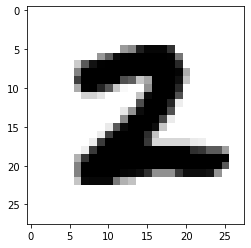

In [5]:
images, labels  = next(iter(train_loader))
print(images.shape)
print(labels.shape)
# printing random image and seeing
plt.imshow(images[random.randint(0,len(images))].numpy().squeeze(), cmap='gray_r')

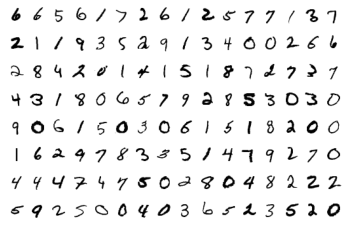

In [6]:
# Looking at more images
figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

### Network

In [7]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__() # extending super class method

    # Conv Block 1
    self.conv1 = nn.Conv2d(1,32,3, padding=1) # In- 1x28x28, Out- 32x28x28, RF- 3x3, Jump_in -1, Jump_out -1
    self.conv2 = nn.Conv2d(32,64,3, padding=1) # In- 32x28x28, Out- 64x28x28, RF- 5x5, Jump_in -1, Jump_out -1
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 64x28x28, Out- 64x14x14, RF- 6x6, Jump_in -1, Jump_out -2

    # Conv Block 2
    self.conv3 = nn.Conv2d(64,128,3, padding=1) # In- 64x14x14, Out- 128x14x14, RF- 10x10, Jump_in -2, Jump_out -2
    self.conv4 = nn.Conv2d(128,256,3, padding=1) # In- 128x14x14, Out- 256x14x14, RF- 14x14, Jump_in -2, Jump_out -2
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 256x14x14, Out- 256x7x7, RF- 16x16, Jump_in -2, Jump_out -4

    # Conv Block 3
    self.conv5 = nn.Conv2d(256,512,3, padding=0) # In- 256x7x7, Out- 512x5x5, RF- 18x18, Jump_in -4, Jump_out -4
    self.conv6 = nn.Conv2d(512,1024,3, padding=0) # In- 512x5x5, Out- 1024x3x3, RF- 26x26, Jump_in -4, Jump_out -4
    self.conv7 = nn.Conv2d(1024,10,3) # In- 1024x3x3, Out- 10x1x1, RF- 34x34, Jump_in -4, Jump_out -4

  
  def forward(self,x):

    # Block 1
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.pool1(x))

    # Block 2
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.pool2(x))

    # Block 3
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.conv7(x)

    # Flattening
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)

# model = Network()
# print(model)

### Model Params
  - Checking the model summary and number of parameters

In [8]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Network().to(device)
# print(model)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
--------------------------------

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Training and Testing
- includes test and train functions
- includes loop function, where test can happen after each epoch is trained


In [9]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch):
  model.train() # setting the model in training mode
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = F.nll_loss(y_preds,labels) # capturing loss
    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accuracy.append(100*correct/processed)


In [10]:
# Test Function
test_losses = [] # to capture test losses 
test_accuracy = [] # to capture test accuracy 

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector 

      test_loss = F.nll_loss(outputs,labels, reduction='sum').item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))


In [11]:
model =  Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.07930511981248856 Batch_id=468 Accuracy=85.99: 100%|██████████| 469/469 [00:38<00:00, 12.31it/s]



Test set: Average loss: 0.0000, Accuracy: 9782/10000 (97.82%)

EPOCH: 1


Loss=0.02060229890048504 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:38<00:00, 12.29it/s]



Test set: Average loss: 0.0000, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Loss=0.011869699694216251 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]



Test set: Average loss: 0.0000, Accuracy: 9858/10000 (98.58%)

EPOCH: 3


Loss=0.04851561784744263 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:38<00:00, 12.24it/s]



Test set: Average loss: 0.0001, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.002646444132551551 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:38<00:00, 12.24it/s]



Test set: Average loss: 0.0000, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.0014048594748601317 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]



Test set: Average loss: 0.0003, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.040985364466905594 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]



Test set: Average loss: 0.0000, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.02648058533668518 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:38<00:00, 12.28it/s]



Test set: Average loss: 0.0000, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.008055493235588074 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:38<00:00, 12.21it/s]



Test set: Average loss: 0.0000, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.0016365378396585584 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:38<00:00, 12.26it/s]



Test set: Average loss: 0.0000, Accuracy: 9904/10000 (99.04%)

EPOCH: 10


Loss=0.0005929535836912692 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]



Test set: Average loss: 0.0000, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.0004274636448826641 Batch_id=468 Accuracy=99.84: 100%|██████████| 469/469 [00:38<00:00, 12.25it/s]



Test set: Average loss: 0.0000, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.008311138488352299 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:38<00:00, 12.26it/s]



Test set: Average loss: 0.0000, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.0011456857901066542 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:38<00:00, 12.25it/s]



Test set: Average loss: 0.0000, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.0005474028293974698 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]



Test set: Average loss: 0.0000, Accuracy: 9918/10000 (99.18%)



Experiment Number	: 1

Objective / Target	
- Initial Setup and Model
- Getting the model correct
- Very basic model"

Results	
- Parameters: 6,379,786
- Best Train Accuracy: 99.92 %
- Best Test Accuracy: 99.21 %

Analysis	
- Large but working model
- Overfitting (train - test accuracy) > 0

Next Steps	
- Reduce Number of Params